In [1]:
import pandas as pd
import xgboost as xgb
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from sklearn import neural_network as nn
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Permuted Data")
df

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


,Standardized_SMILES,pchembl_value,MolWt,LogP,QED
0,Brc1cncc(COCC2(c3ccccc3)CCNCC2)c1,4.82,361.283,3.6821,0.882288
1,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCCCC...,6.70,397.526,6.4497,0.416926
2,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCCCC...,6.47,398.514,4.8690,0.460447
3,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCOCC...,5.39,399.498,5.2960,0.490800
4,C1=NCCC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCC...,7.05,397.526,6.1021,0.438245
...,...,...,...,...,...
1257,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(-c2cscn2...,5.36,405.527,4.3692,0.472923
1258,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C24CC5CC...,6.30,456.634,5.7135,0.472659
1259,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C2CCCCC2...,6.87,404.558,5.2934,0.555363
1260,c1cncc(-c2c[nH]c(C3Cc4c([nH]c5ccccc45)C(C4CCCC...,6.72,397.526,5.4614,0.429771


In [2]:
# Generate Morgan Fingerprints
def generate_fingerprints(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))
    else:
        return np.zeros((nBits,))

df['Fingerprints'] = df['Standardized_SMILES'].apply(generate_fingerprints)

# Prepare features and target
X = np.array(list(df['Fingerprints']))
y = df['pchembl_value'].values

In [3]:
smiles = df['Standardized_SMILES'].values

In [4]:
MolWt = df['MolWt'].values
LogP = df['LogP'].values
QED=df['QED'].values

In [5]:
df

,Standardized_SMILES,pchembl_value,MolWt,LogP,QED,Fingerprints
0,Brc1cncc(COCC2(c3ccccc3)CCNCC2)c1,4.82,361.283,3.6821,0.882288,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCCCC...,6.70,397.526,6.4497,0.416926,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCCCC...,6.47,398.514,4.8690,0.460447,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCOCC...,5.39,399.498,5.2960,0.490800,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,C1=NCCC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCC...,7.05,397.526,6.1021,0.438245,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
1257,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(-c2cscn2...,5.36,405.527,4.3692,0.472923,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1258,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C24CC5CC...,6.30,456.634,5.7135,0.472659,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1259,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C2CCCCC2...,6.87,404.558,5.2934,0.555363,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1260,c1cncc(-c2c[nH]c(C3Cc4c([nH]c5ccccc45)C(C4CCCC...,6.72,397.526,5.4614,0.429771,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [6]:
#Now incorporate this sort of noise into df during the training

In [7]:
X.shape

(1262, 2048)

In [8]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from math import sqrt

def perform_fcv(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]

    rmse=list()
    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample
    
    
    train_df=pd.DataFrame()
    test_df=pd.DataFrame()

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        
        model = xgb.XGBRegressor(n_estimators=min(25, round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
                                      
        X_test = X[start:stop]
        y_test = y[start:stop]
        smiles_test = smiles[start:stop]
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        #print(discoveries.shape)
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        #print(discoveries.shape)
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        smiles_train=np.concatenate([smiles[:start]])
        training_df=pd.DataFrame({
            'Standardized_SMILES': smiles_train,
        'True Values': y_train,
        'Predictions': model.predict(X_train)
        })
        
        training_df.insert(0,'training batch',(i+1))
        train_df=pd.concat([train_df,training_df]).reset_index(drop=True)
        testing_df=pd.DataFrame({
            'Standardized_SMILES': smiles_test,
        'True Values': y_test,
        'Predictions': predictions
        })
        testing_df.insert(0,'testing batch',(i+1))
        test_df=pd.concat([test_df,testing_df]).reset_index(drop=True)
        
        
        
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    
    # Saving to CSV (optional)
    train_df.to_csv("unsorted_fcv_results_xgboost_training batches.csv", index=False)
    test_df.to_csv("unsorted_fcv_results_xgboost_testing batches.csv", index=False)
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
        
    })

    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

In [9]:

# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df, false_disc, true_disc, true_ignore, false_ignore,rmse = perform_fcv(X, y, smiles, sort_by=None, additional_info=df["QED"])

(0.4736184324329246, 2.1292857957284885e-08)
(0.5468292046475483, 3.486797361010312e-11)
(0.6400211020903712, 7.131251021329948e-16)
(0.7901704023712647, 3.8884135562315444e-28)
(0.7907369463151861, 3.3511147707239393e-28)
(0.7671010119475806, 1.1527071286681448e-25)
(0.7843025952204364, 1.7667356415418915e-27)
(0.8938873001678239, 4.9629618842456114e-45)
(0.7927486800184684, 7.258168138874449e-29)


In [10]:
for i in np.arange(len(true_disc)):
    print(true_disc[i].shape)

(20, 3)
(28, 3)
(29, 3)
(21, 3)
(16, 3)
(15, 3)
(28, 3)
(36, 3)
(23, 3)


In [11]:
for i in np.arange(len(true_disc)):
    print(false_disc[i].shape)

(31, 3)
(7, 3)
(23, 3)
(13, 3)
(1, 3)
(8, 3)
(12, 3)
(4, 3)
(8, 3)


In [12]:
for i in np.arange(len(true_disc)):
    print(false_ignore[i].shape)

(19, 3)
(29, 3)
(20, 3)
(27, 3)
(17, 3)
(13, 3)
(23, 3)
(19, 3)
(22, 3)


In [13]:
for i in np.arange(len(true_disc)):
    print(true_ignore[i].shape)

(54, 3)
(59, 3)
(53, 3)
(64, 3)
(90, 3)
(84, 3)
(60, 3)
(65, 3)
(73, 3)


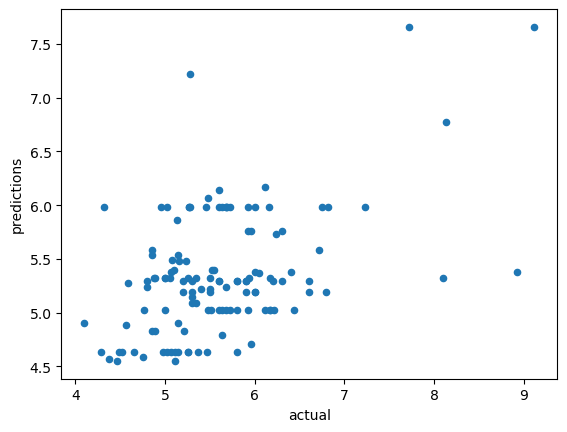

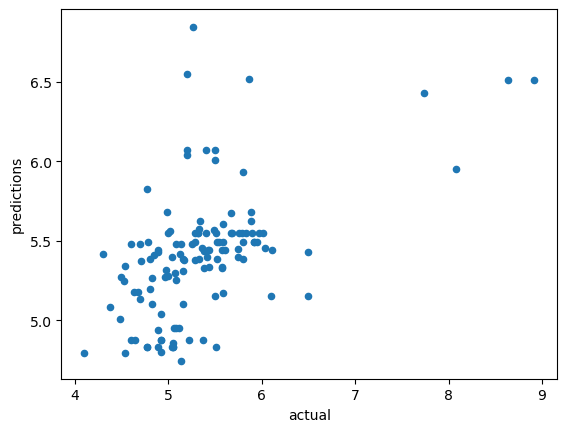

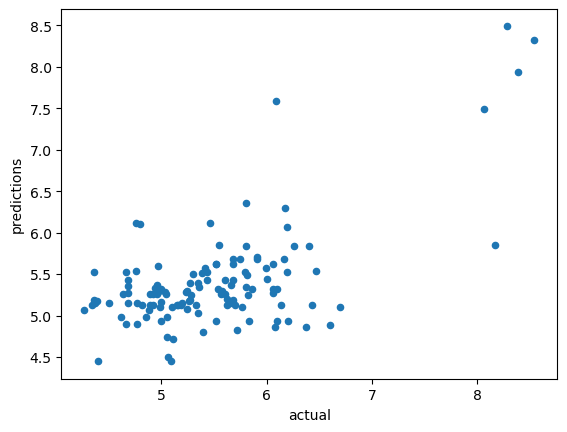

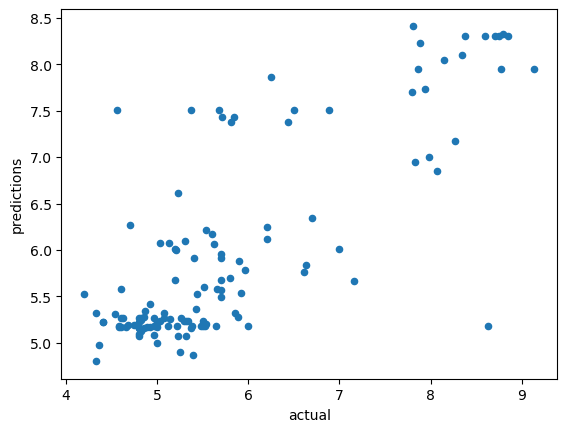

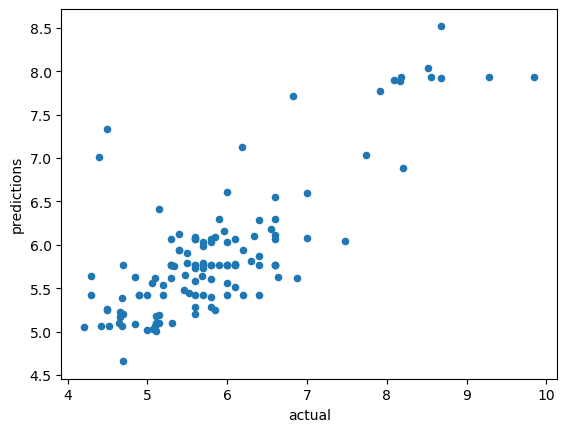

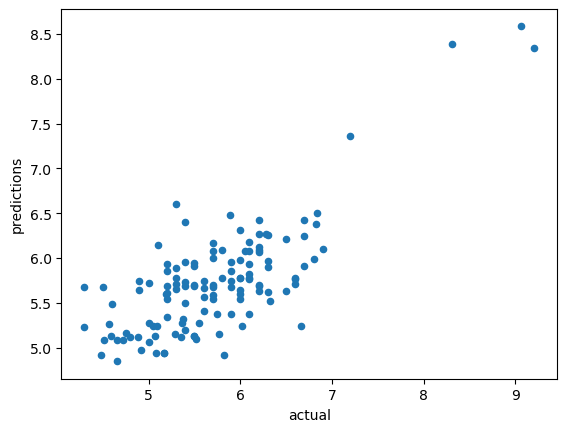

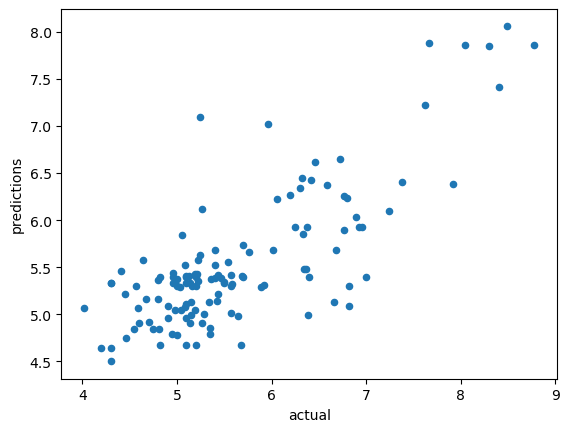

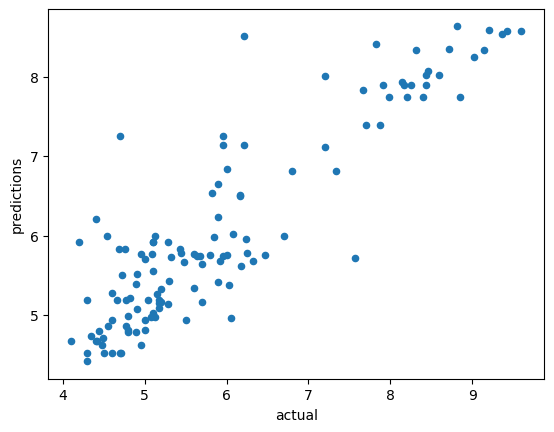

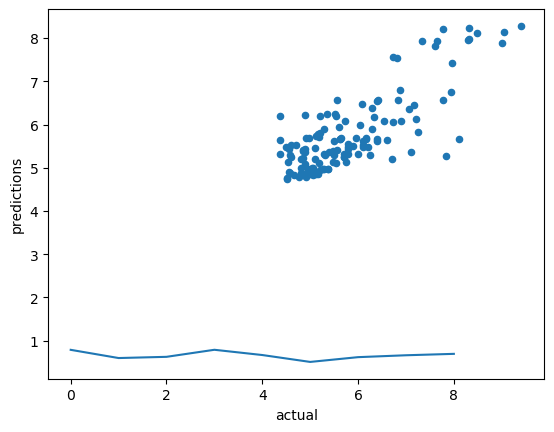

[0.7880766892675595, 0.5981643361196929, 0.6261758777634181, 0.7893282458980019, 0.6678302035651505, 0.5083881201695463, 0.6186944048969206, 0.6624274252393892, 0.6950629515209038]


In [14]:
plt.plot(rmse)
plt.show()
print(rmse)

In [26]:
def plot_graphs(data, results_df):
    
    results_df =pd.merge(data, results_df, 
                         left_on="Standardized_SMILES", right_on="Standardized_SMILES")
    
    # Calculate absolute errors and adjust results
    results_df['Error'] = (results_df['True Values'] - results_df['Predictions']).abs().round(2)
    results_df['True Values'] = results_df['True Values'].round(2)
    results_df['Predictions'] = results_df['Predictions'].round(2)

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['MolWt'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By MolWt')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
        # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['QED'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By QED')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['LogP'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By LogP')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['pchembl_value'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By IC50 Sorted')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()

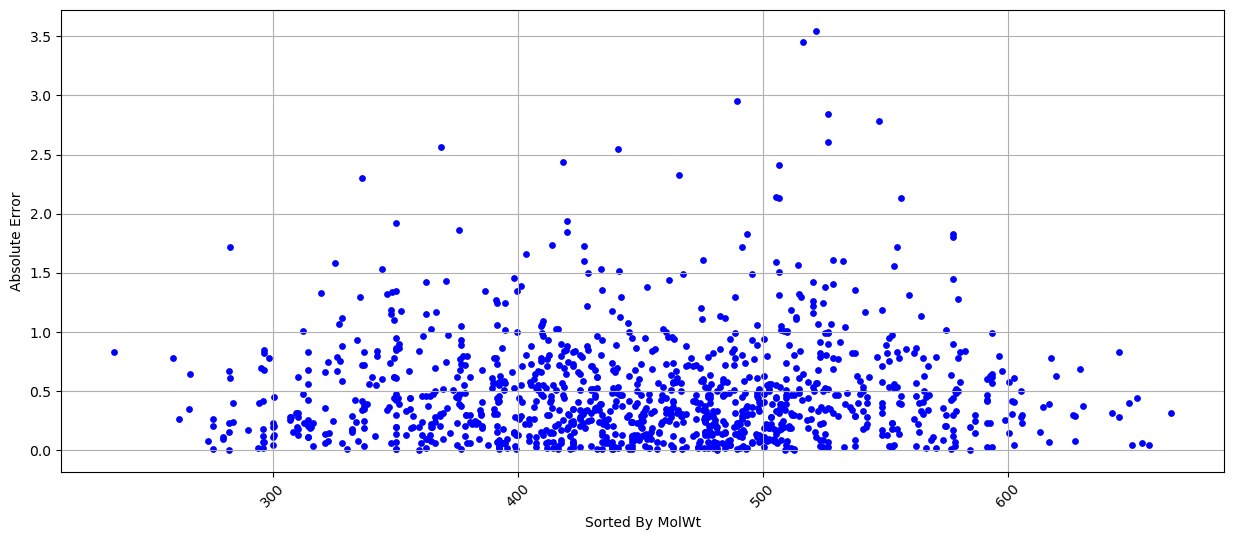

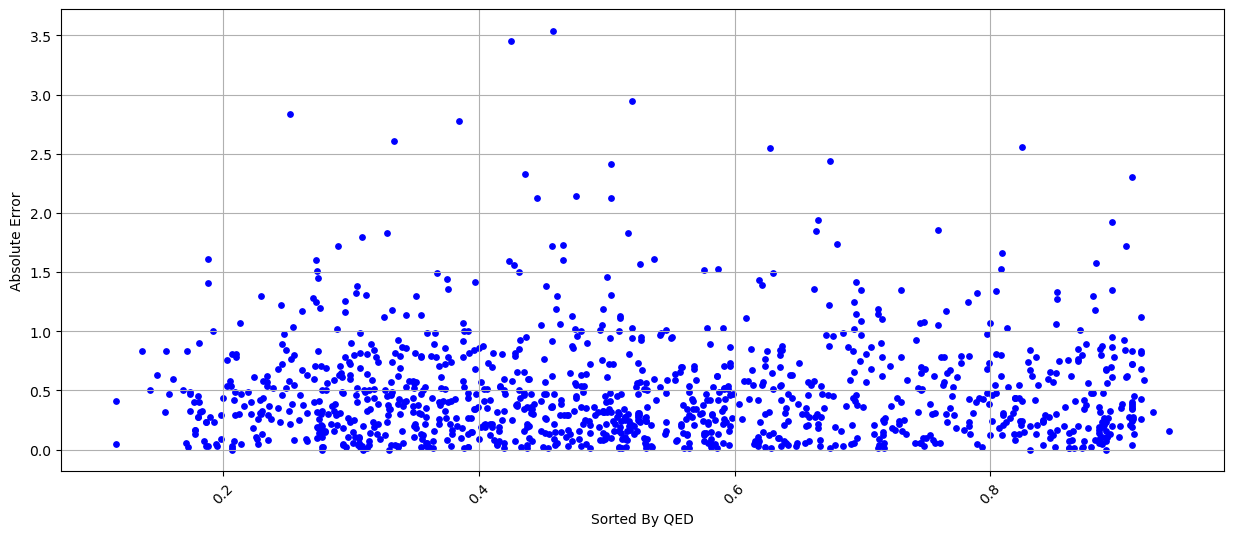

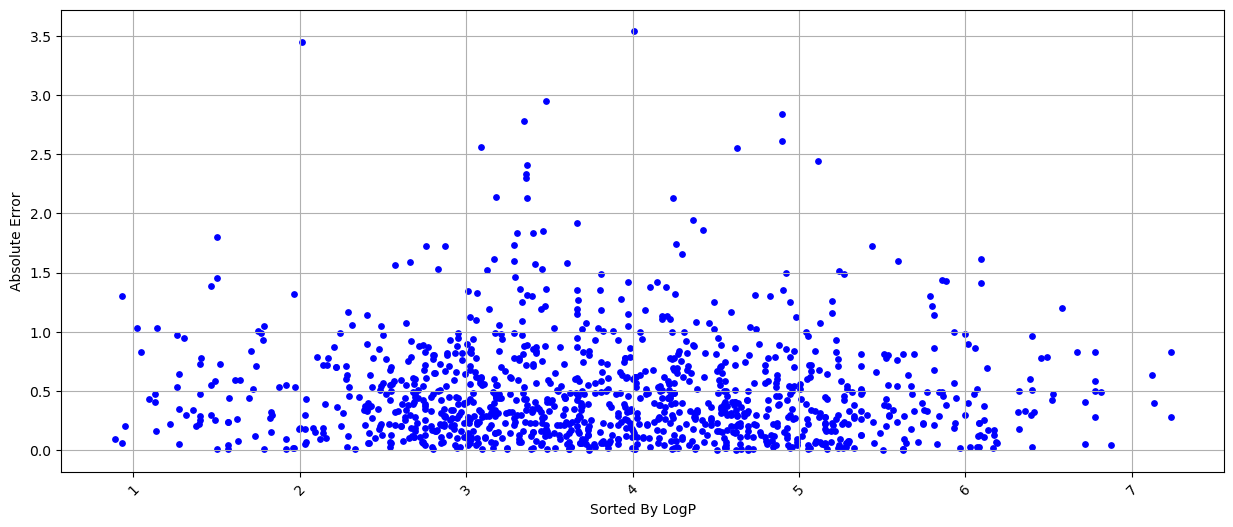

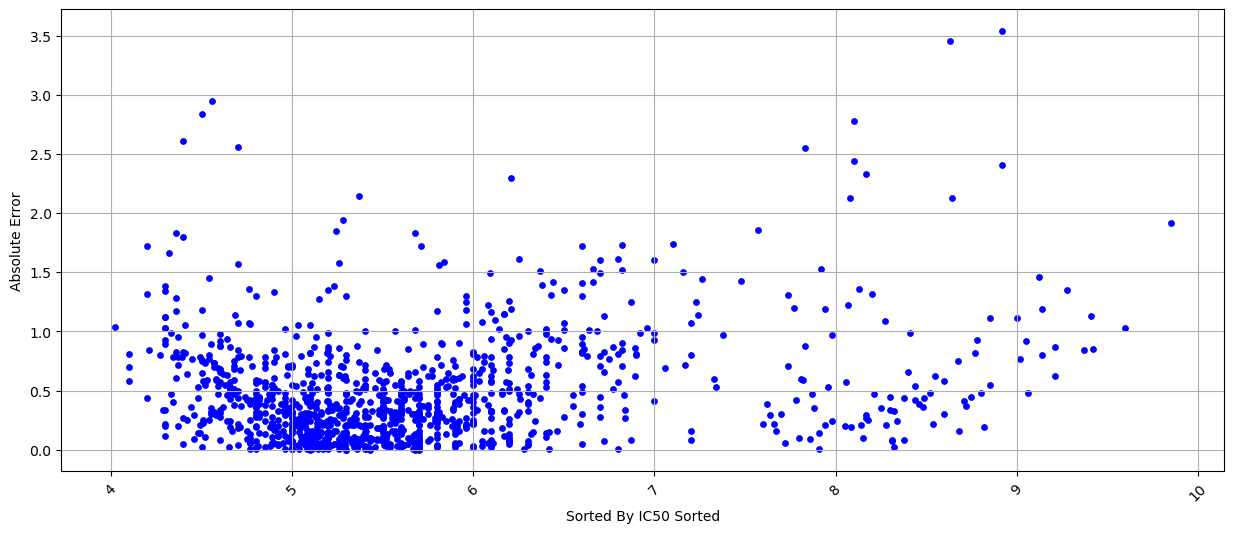

In [27]:
plot_graphs(df, results_df)

In [28]:
import random
df_copy=df.copy().sort_values(by="QED")#regular sort 
df_copy.plot(y="pchembl_value",use_index=False) #probabilities of each molecule being selected upon random selection without replacement
df_copy.plot(y="QED",use_index=False)

indices=df.nlargest(round(len(X)/10), ['QED']).index
X_test=X.copy()[indices]
y_test=y.copy()[indices]
smiles_test=smiles[indices]

X1=np.delete(X.copy(),indices,axis=0)
y1=np.delete(y.copy(),indices,axis=0)
smiles1=np.delete(smiles.copy(),indices,axis=0)


#X[df.nlargest(126, ['QED']).index].shape

In [29]:
#Calculating Discovery metrics on most drug-like candidates

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def perform_fcv_on_most_druglike(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    rmse=list()
    train_df=pd.DataFrame()
    test_df=pd.DataFrame()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]


    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        

        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]
        
        model = xgb.XGBRegressor(n_estimators=min(25, round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        smiles_train=np.concatenate([smiles[:start]])
        training_df=pd.DataFrame({
            'Standardized_SMILES': smiles_train,
        'True Values': y_train,
        'Predictions': model.predict(X_train)
        })
        
        training_df.insert(0,'training batch',(i+1))
        train_df=pd.concat([train_df,training_df]).reset_index(drop=True)
        testing_df=pd.DataFrame({
            'Standardized_SMILES': smiles_test,
        'True Values': y_test,
        'Predictions': predictions
        })
        testing_df.insert(0,'testing batch',(i+1))
        test_df=pd.concat([test_df,testing_df]).reset_index(drop=True)
        
        
        
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    
    # Saving to CSV (optional)
    train_df.to_csv("unsorted_fcv_results_xgboost_training batches_druglike.csv", index=False)
    test_df.to_csv("unsorted_fcv_results_xgboost_testing batches_druglike.csv", index=False)
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
    })


    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

In [30]:


results_df2, false_disc2, true_disc2, true_ignore2, false_ignore2,rmse = perform_fcv_on_most_druglike(X1, y1, smiles1, sort_by=None, additional_info=df["QED"])

(0.5688055683605792, 3.693823791141675e-12)
(0.8469826738722398, 7.938604008292304e-36)
(0.8410793428010771, 6.851403667528854e-35)
(0.8232777013781855, 2.767720923652514e-32)
(0.7999410699954519, 2.8001609464443274e-29)
(0.8536207547009779, 6.292719710585324e-37)
(0.8392348139403938, 1.3196061054854196e-34)
(0.8520295144852428, 1.1685126367859036e-36)
(0.8747228821501933, 7.972216635132447e-41)


In [31]:
for i in np.arange(len(true_disc2)):
    print(true_disc2[i].shape)

(4, 3)
(2, 3)
(15, 3)
(14, 3)
(8, 3)
(10, 3)
(11, 3)
(4, 3)
(5, 3)


In [32]:
for i in np.arange(len(true_disc2)):
    print(false_disc2[i].shape)

(2, 3)
(3, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(3, 3)
(1, 3)
(0, 3)


In [33]:
for i in np.arange(len(true_disc2)):
    print(true_ignore2[i].shape)

(75, 3)
(74, 3)
(76, 3)
(76, 3)
(76, 3)
(76, 3)
(74, 3)
(76, 3)
(77, 3)


In [34]:
for i in np.arange(len(true_disc2)):
    print(false_ignore2[i].shape)

(44, 3)
(46, 3)
(33, 3)
(34, 3)
(40, 3)
(38, 3)
(37, 3)
(44, 3)
(43, 3)


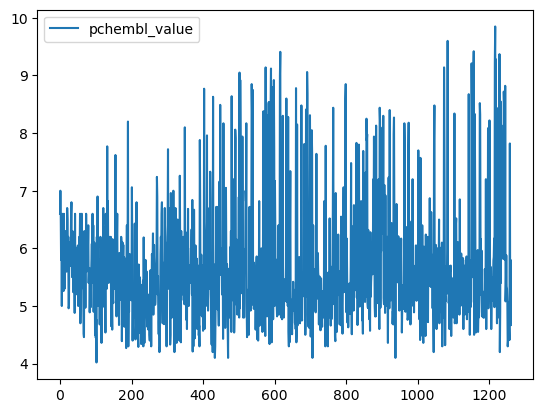

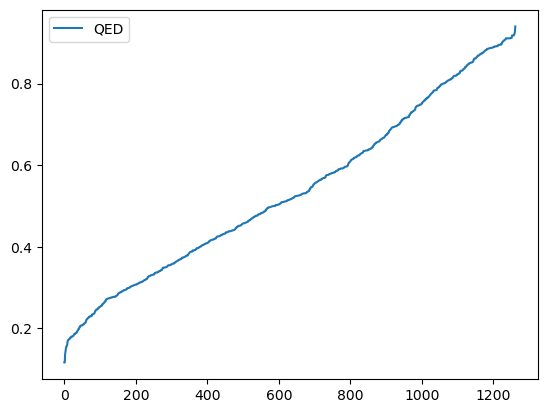

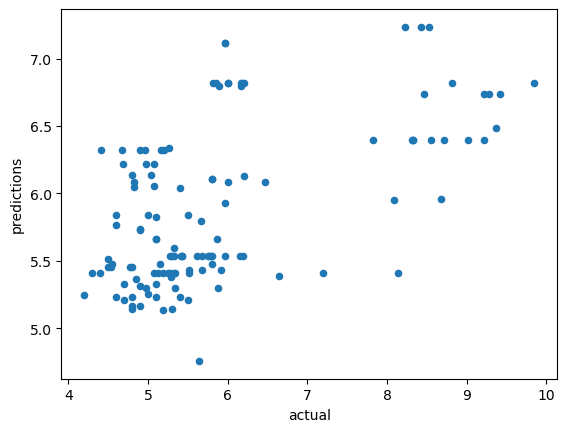

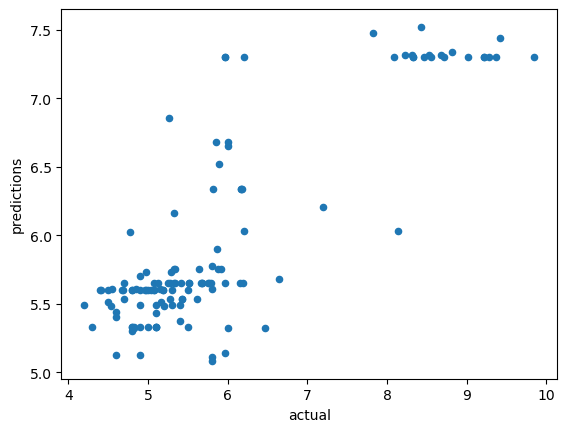

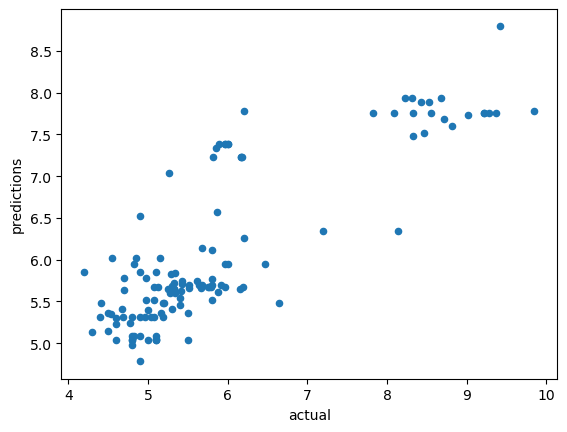

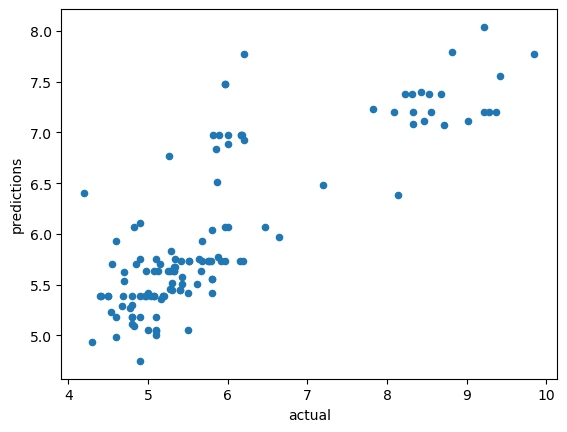

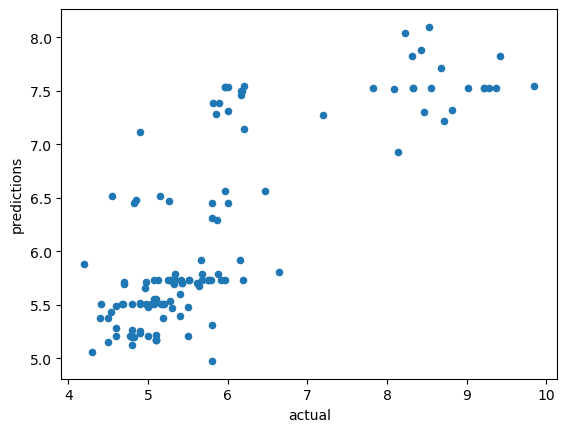

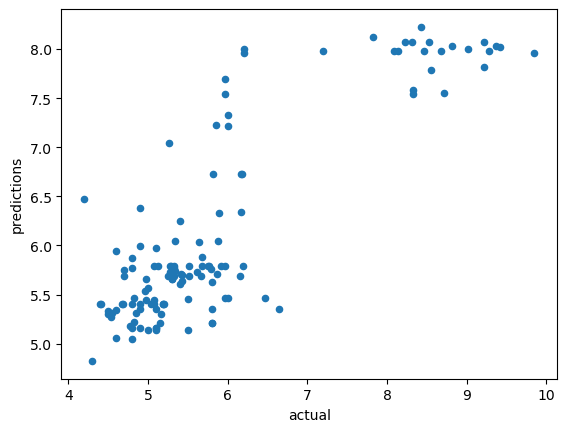

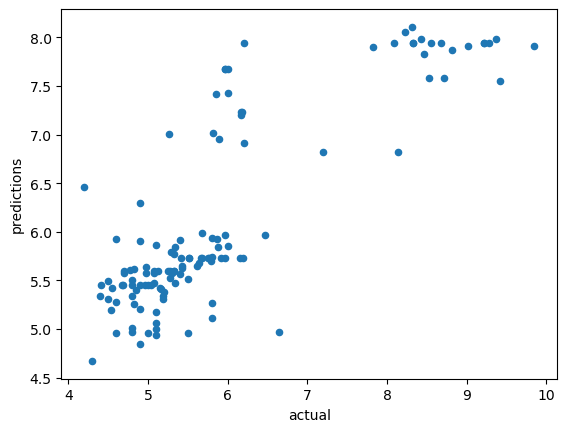

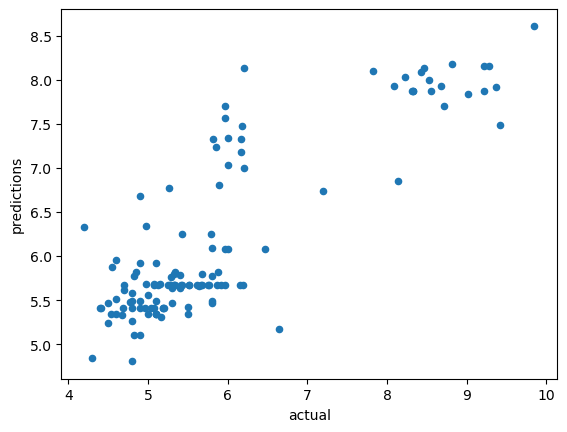

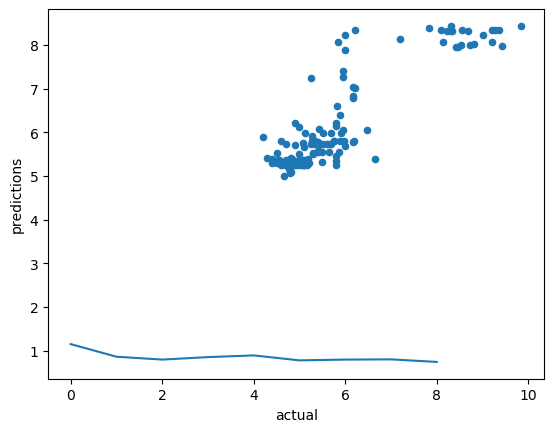

[1.1478562482364605, 0.8589594706260223, 0.7933206632830268, 0.8501052475719758, 0.8889471009312121, 0.775496598749103, 0.7933907764344851, 0.798294259503963, 0.739830625506786]


In [35]:
plt.plot(rmse)
plt.show()
print(rmse)